Before we look at any specific trial, what is the default probability of success?
- Serves as a baseline (intercept is calculated using Log-Odds)

In [5]:
import pandas as pd

# 1. Load the data the model was trained on
df = pd.read_csv('../data/processed/cleaned_trials.csv')

# 2. Count the winners
total_trials = len(df)
successes = df['target_outcome'].sum() # Sum of 1s
failures = total_trials - successes

# 3. Calculate the %
success_rate = successes / total_trials

print(f"Total Trials: {total_trials}")
print(f"Successes (1): {successes}")
print(f"Failures (0):  {failures}")
print(f"Success Rate:  {success_rate:.2%}")
print("\nConclusion: The model starts optimistic because most trials in history have succeeded.")

Total Trials: 261
Successes (1): 213
Failures (0):  48
Success Rate:  81.61%

Conclusion: The model starts optimistic because most trials in history have succeeded.


Now we add the specific details of our default trial. Each feature adds or subtracts from the baseline score.

In [6]:
import pandas as pd
import joblib

# 1. Load the Model
model_pipeline = joblib.load('../models/logistic_regression.pkl')
model = model_pipeline.named_steps['classifier']
preprocessor = model_pipeline.named_steps['preprocessor']

# 2. Get all the "Price Tags" (Coefficients)
feature_names = preprocessor.get_feature_names_out()
coeffs = model.coef_[0]
intercept = model.intercept_[0]

# 3. Create a Lookup Table
df_weights = pd.DataFrame({'Feature': feature_names, 'Weight': coeffs})

print(f"THE BASE (Intercept): {intercept:.4f}")
print("-" * 30)

# 4. Search for the features in your "Success" JSON
# Note: 'non-small cell lung cancer' might trigger multiple features (cond_non, cond_small, cond_lung)
keywords = ['phase3', 'pfizer', 'enrollment', 'lung', 'non', 'small']

for term in keywords:
    # Find features that match the term
    matches = df_weights[df_weights['Feature'].str.contains(term, case=False)]
    if not matches.empty:
        print(f"\nFound match for '{term}':")
        print(matches.to_string(index=False))

THE BASE (Intercept): 1.3951
------------------------------

Found match for 'phase3':
             Feature    Weight
remainder__is_phase3 -0.513097

Found match for 'pfizer':
                  Feature   Weight
remainder__sponsor_Pfizer 0.096947

Found match for 'enrollment':
            Feature   Weight
num__enrollment_log 1.132718

Found match for 'lung':
                    Feature    Weight
  remainder__cond_cell lung -0.085222
       remainder__cond_lung  0.261359
remainder__cond_lung cancer  0.034601

Found match for 'non':
                      Feature    Weight
remainder__cond_carcinoma non -0.129165
 remainder__cond_lymphoma non  0.163643
          remainder__cond_non  0.099785
  remainder__cond_non hodgkin -0.191198
    remainder__cond_non small -0.022551

Found match for 'small':
                   Feature    Weight
 remainder__cond_non small -0.022551
     remainder__cond_small -0.081081
remainder__cond_small cell -0.146941


The score is roughly +2.5 to +3.5. But humans don't understand 'Log-Odds.' We use the Sigmoid function to translate this into a probability.

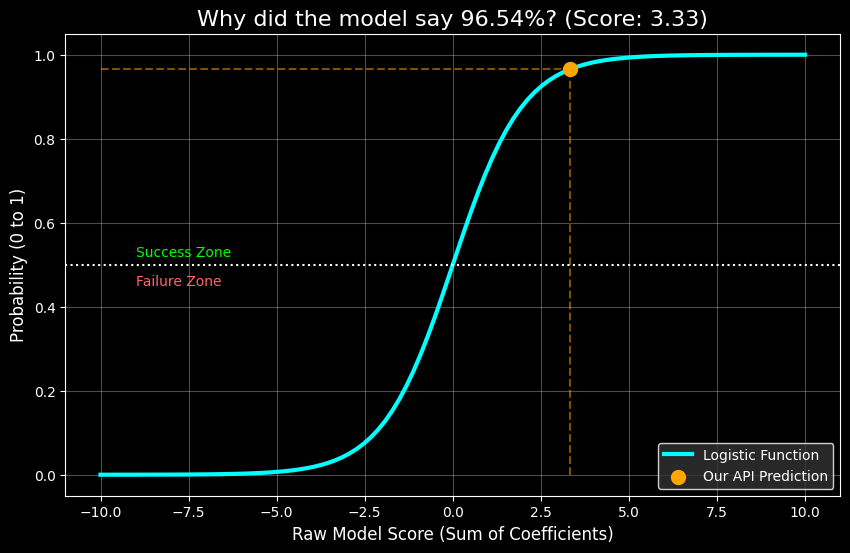

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# 1. The "Score" (Log-Odds)
# This is the raw math the model calculates: (Coeff * Value) + Intercept
# Create list of 100 numbers from -10 to 10
# These represent possible raw scores from the model
# -10 -> very negative prediction, 0 -> neutral, +10 -> very positive prediction
z_scores = np.linspace(-10, 10, 100)

# 2. The Sigmoid Function (The "Squishifier")
# It takes that raw score and squishes it between 0 and 1.
# 1 / (1 + e^(-z))
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

probabilities = sigmoid(z_scores)

# 3. Draw the Brain
plt.figure(figsize=(10, 6))
plt.plot(z_scores, probabilities, color='cyan', linewidth=3, label='Logistic Function')

# Add our API example (from your earlier test)
# The model gave a probability of 0.9654.
# Let's find the "Score" that produced that.
example_prob = 0.9654
# Working backward from the answer of 96.54% to find out what the raw score was
# Since the API gives only probablility, not raw scores
example_score = np.log(example_prob / (1 - example_prob)) # Inverse Sigmoid (Logit)

plt.scatter([example_score], [example_prob], color='orange', s=100, zorder=5, label='Our API Prediction')
plt.plot([example_score, example_score], [0, example_prob], color='orange', linestyle='--', alpha=0.5)
plt.plot([-10, example_score], [example_prob, example_prob], color='orange', linestyle='--', alpha=0.5)

plt.title(f"Why did the model say 96.54%? (Score: {example_score:.2f})", fontsize=16)
plt.xlabel("Raw Model Score (Sum of Coefficients)", fontsize=12)
plt.ylabel("Probability (0 to 1)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(facecolor='#333333', edgecolor='white')
plt.axhline(0.5, color='white', linestyle=':', label='Decision Threshold')
plt.text(-9, 0.52, "Success Zone", color='#00ff00')
plt.text(-9, 0.45, "Failure Zone", color='#ff6666')

plt.savefig('../reports/figures/logistic_regression_sigmoid.png', dpi=300, bbox_inches='tight')

plt.show()